In [1]:
import sys
sys.path.append("..")
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]
torch.manual_seed(0)

from engression import engression
from engression.data.loader import partition_data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
data = pd.read_csv("../engression/data/resources/air_quality.csv")
x_full = torch.Tensor(data["PT08.S2.NMHC."]).unsqueeze(1).to(device)
y_full = torch.Tensor(data["PT08.S3.NOx."]).unsqueeze(1).to(device)
# partition training/test
x_tr, y_tr, x_te, y_te, x_full_normal = partition_data(x_full, y_full, 0.3, "smaller")

In [4]:
# Fit an engression model
engressor = engression(x_tr, y_tr, num_layer=6, hidden_dim=100, noise_dim=100, 
                       lr=0.005, num_epoches=1500, print_every_nepoch=500, device=device)

Running on CPU.

As NN has more than 2 layers, residual blocks are used by default; turn it off by setting 'resblock=False'.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.7116,  E(|Y-Yhat|): 1.0389,  E(|Yhat-Yhat'|): 0.6548
[Epoch 500 (33%)] energy-loss: 0.3673,  E(|Y-Yhat|): 0.7372,  E(|Yhat-Yhat'|): 0.7397
[Epoch 1000 (67%)] energy-loss: 0.3776,  E(|Y-Yhat|): 0.7577,  E(|Yhat-Yhat'|): 0.7602
[Epoch 1500 (100%)] energy-loss: 0.3818,  E(|Y-Yhat|): 0.7440,  E(|Yhat-Yhat'|): 0.7243

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.3863,  E(|Y-Yhat|): 0.7419,  E(|Yhat-Yhat'|): 0.7111

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- conside

In [5]:
# Summarize model information
engressor.summary()

Engression model with
	 number of layers: 6
	 hidden dimensions: 100
	 noise dimensions: 100
	 residual blocks: True
	 number of epochs: 1500
	 batch size: 2707
	 learning rate: 0.005
	 standardization: True
	 training mode: False
	 device: cpu

Training loss (original scale):
	 energy-loss: 0.39, 
	E(|Y-Yhat|): 0.74, 
	E(|Yhat-Yhat'|): 0.71


In [6]:
# Evaluation
print("L2 loss:", engressor.eval_loss(x_te, y_te, loss_type="l2"))
print("correlation between predicted and true means:", engressor.eval_loss(x_te, y_te, loss_type="cor"))
print("energy score:", engressor.eval_loss(x_te, y_te, loss_type="energy"))

L2 loss: 0.2894739806652069
correlation between predicted and true means: 0.6952826976776123
energy score: 0.29016971588134766


In [7]:
# prediction
y_pred = engressor.predict(x_full_normal)

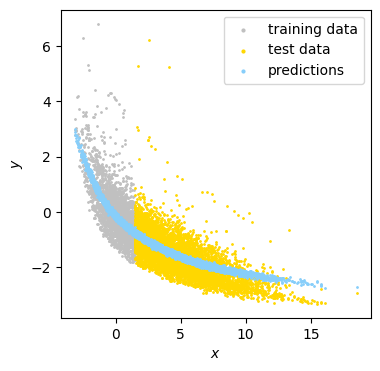

In [8]:
engressor.plot(x_te, y_te, x_tr, y_tr)

## Baseline: $L_2$ regression

In [9]:
from engression.models import ResMLP

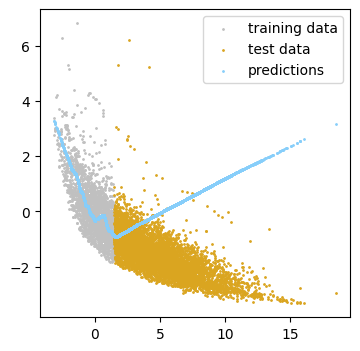

In [10]:
# Build a model with the same architecture
model = ResMLP(num_layer=6, hidden_dim=100) # NN with the same architecture
opt = torch.optim.Adam(model.parameters(), lr=0.005) # same optimizer

# L2 regression training
model.train()
for i in range(1500):
    model.zero_grad()
    y_pred = model(x_tr)
    loss = (y_pred - y_tr).pow(2).mean()
    loss.backward()
    opt.step()

# Evaluation
model.eval()
y_pred = model(x_full_normal).detach()
plt.scatter(x_tr.cpu(), y_tr.cpu(), label="training data", s=1, color="silver")
plt.scatter(x_te.cpu(), y_te.cpu(), label="test data", s=1, color="goldenrod")
plt.scatter(x_full_normal.cpu(), y_pred.cpu(), label="predictions", s=1, color="lightskyblue")
plt.legend(); plt.show()